<a href="https://colab.research.google.com/github/aaronjoseph/siim-covid19-detection/blob/master/EDA_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo pip install --upgrade --force-reinstall --no-deps "kaggle>=1.5.12"

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=368f3478d88e88e0596c4a92572b4d8383a1e6e4862b7a0da647051e2450d483
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"aaronjoseph","key":"1fa60446a1bf44f239d2ca4ddda1d9f4"}
import json
import zipfile
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pprint
!pip install pydicom
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A
import cv2
!pip install wandb
import wandb
from PIL import Image
!pip install colorama
from colorama import Fore,Back,Style
# colored output
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
sns.set(font="Serif",style ="white")

     |████████████████████████████████| 1.9MB 3.9MB/s 
     |████████████████████████████████| 1.8MB 4.0MB/s 
     |████████████████████████████████| 133kB 41.2MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 174kB 33.5MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8807 sha256=05c40b9aafdbcfe9778b70d09727149cfdd62708b0dbb987b619bd2677be992c
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6502 sha256=eaca249bb09a066cd675e69a05e32f760a3715e5f036f07cf94539b4672b8325
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [4]:
!kaggle competitions download siim-covid19-detection
!mkdir /content/Input

100% 83.2G/83.2G [12:27<00:00, 111MB/s]
100% 83.2G/83.2G [12:27<00:00, 119MB/s]


In [ ]:
# Code to Unzip and delete the file sucessively

!unzip /content/siim-covid19-detection.zip  -d /content/Input && rm /content/siim-covid19-detection.zip

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["WANDB_SILENT"] = "true"
api_key = user_secrets.get_secret("wand-key")
!wandb login $api_key

In [ ]:
train_image_level = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")
train_study_level = pd.read_csv("../input/siim-covid19-detection/train_study_level.csv")

In [ ]:
train_image_level.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [ ]:
train_study_level.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [ ]:
train_directory = "../input/siim-covid19-detection/train"
test_directory = "../input/siim-covid19-detection/test"
train_study_level['StudyInstanceUID'] = train_study_level['id'].apply(lambda x:x.replace('_study',''))
del train_study_level['id']
train_df = train_image_level.merge(train_study_level, on='StudyInstanceUID')

In [ ]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0


In [ ]:
training_paths = []

for sid in tqdm(train_df['StudyInstanceUID']):
    training_paths.append(glob.glob(os.path.join(train_directory, sid +"/*/*"))[0])
train_df['path'] = training_paths

100%|██████████| 6334/6334 [00:28<00:00, 221.96it/s]


In [ ]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,../input/siim-covid19-detection/train/5776db0c...
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,../input/siim-covid19-detection/train/ff0879eb...
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,../input/siim-covid19-detection/train/9d514ce4...
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,../input/siim-covid19-detection/train/28dddc85...
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,../input/siim-covid19-detection/train/dfd9fdd8...


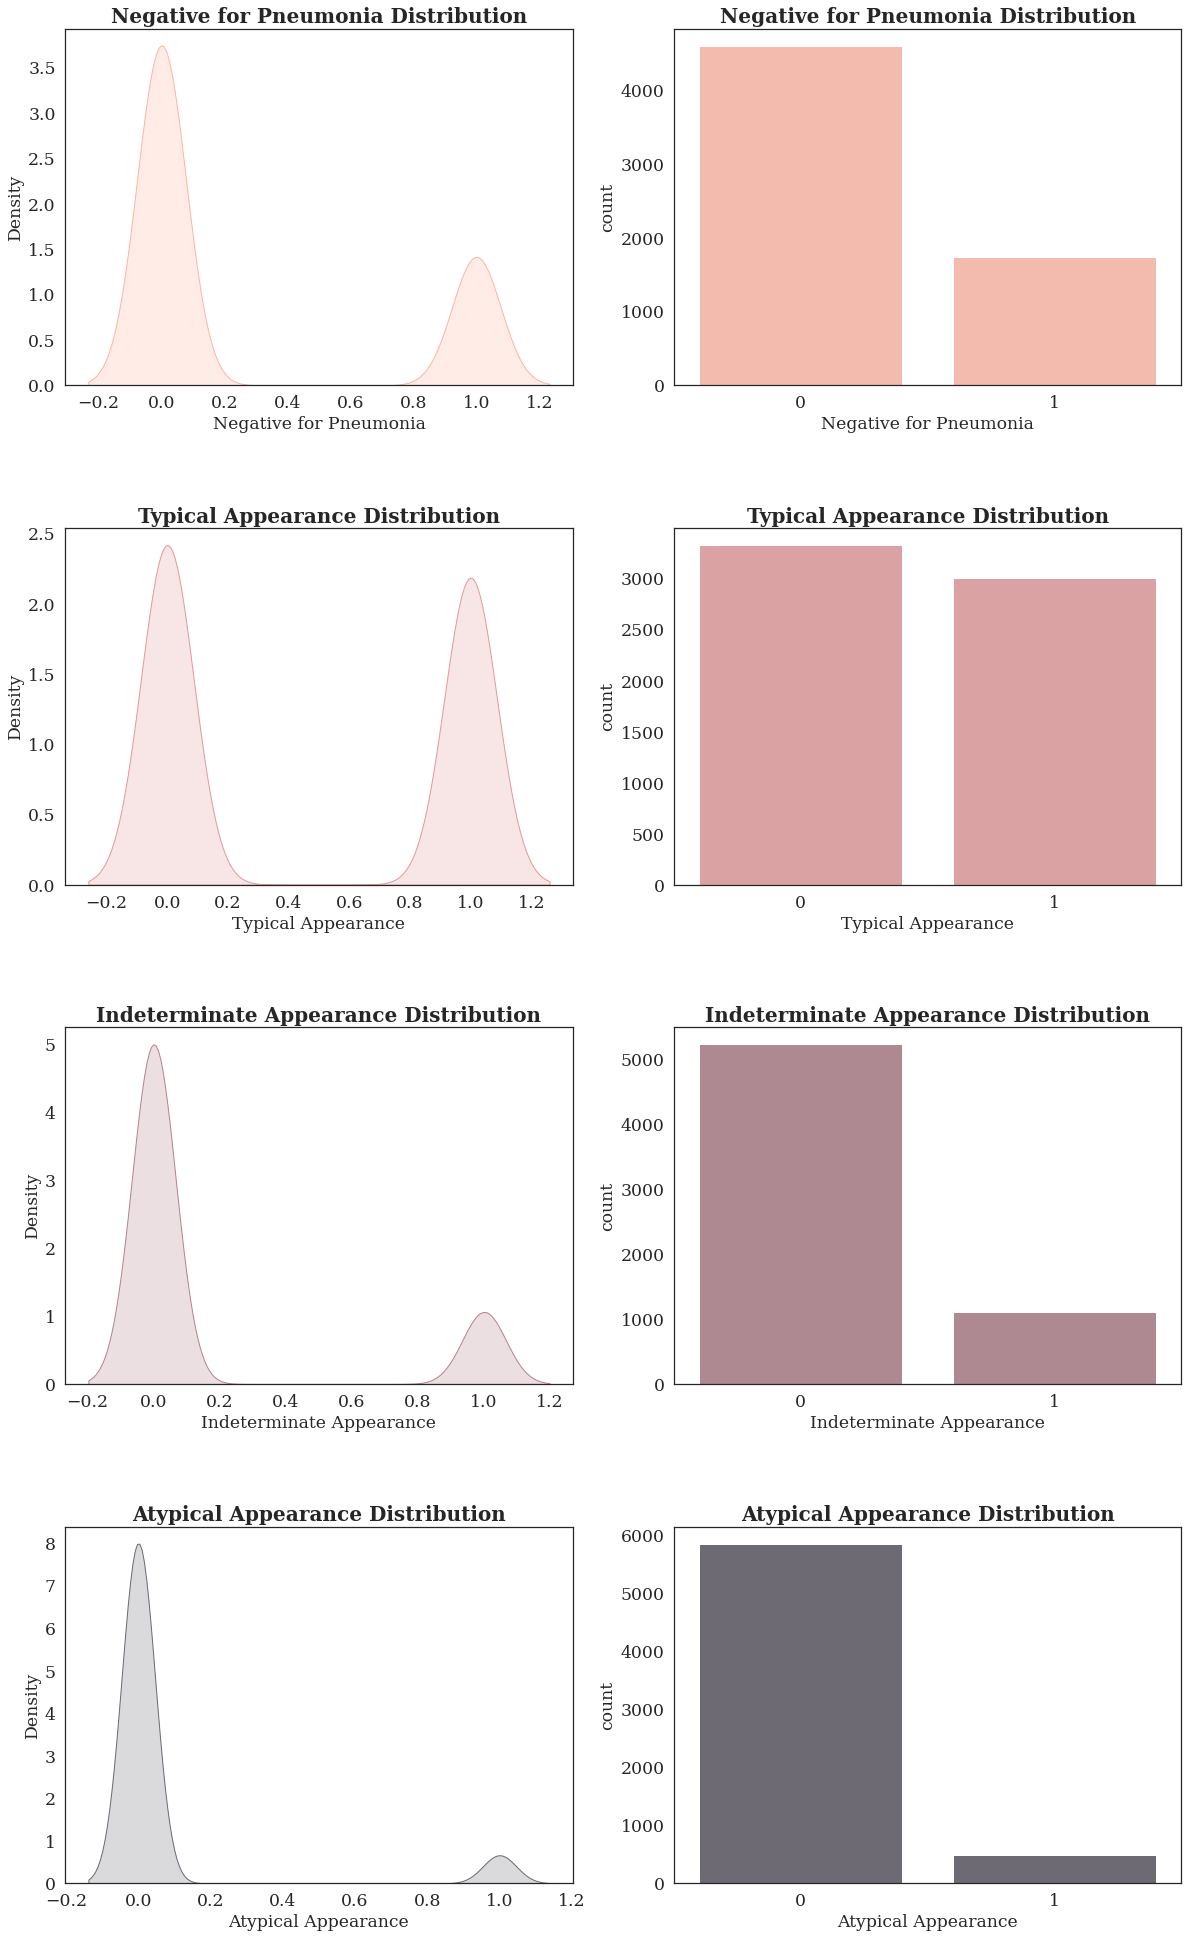

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 32),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots(4,2)
sns.kdeplot(train_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#ffb4a2")
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Negative for Pneumonia"], ax=ax[0,1],color="#ffb4a2")
ax[0,1].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Typical Appearance"], shade=True,ax=ax[1,0],color="#e5989b")
ax[1,0].set_title("Typical Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Typical Appearance"], ax=ax[1,1],color="#e5989b")
ax[1,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Indeterminate Appearance"], shade=True,ax=ax[2,0],color="#b5838d")
ax[2,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Indeterminate Appearance"], ax=ax[2,1],color="#b5838d")
ax[2,1].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Atypical Appearance"], shade=True,ax=ax[3,0],color="#6d6875")
ax[3,0].set_title("Atypical Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Atypical Appearance"], ax=ax[3,1],color="#6d6875")
ax[3,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=20,weight="bold")

fig.subplots_adjust(wspace=0.2, hspace=0.4, top=0.93)
plt.show()

In [ ]:
#====== Function to plot WandB bar chart ======
def plot_wb_bar(df,col1,col2): 
    run = wandb.init(project='siim', job_type='image-visualization',name=col1)
    dt = [[label, val] for (label, val) in zip(df[col1], df[col2])]
    table = wandb.Table(data=dt, columns = [col1,col2])
    wandb.log({col1 : wandb.plot.bar(table, col1,col2,title=col1)})
    run.finish()
    
#====== Function to create a dataframe of value counts ======
def count_values(df,col):
    df = pd.DataFrame(df[col].value_counts().reset_index().values,columns=[col, "counts"])
    return df

plot_wb_bar(count_values(train_df,"Negative for Pneumonia"),"Negative for Pneumonia", 'counts')
plot_wb_bar(count_values(train_df,"Typical Appearance"),"Typical Appearance", 'counts')
plot_wb_bar(count_values(train_df,"Indeterminate Appearance"),"Indeterminate Appearance", 'counts')
plot_wb_bar(count_values(train_df,"Atypical Appearance"),"Atypical Appearance", 'counts')

In [ ]:
# Dicom Data
voi_lut = True
fix_monochrome = True

def dicom_dataset_to_dict(filename,func):
    """Credit: https://github.com/pydicom/pydicom/issues/319
               https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    """
    dicom_header = dicom.dcmread(filename) 
    
    #====== DICOM FILE DATA ======
    dicom_dict = {}
    repr(dicom_header)
    for dicom_value in dicom_header.values():
        if dicom_value.tag == (0x7fe0, 0x0010):
            #discard pixel data
            continue
        if type(dicom_value.value) == dicom.dataset.Dataset:
            dicom_dict[dicom_value.name] = dicom_dataset_to_dict(dicom_value.value)
        else:
            v = _convert_value(dicom_value.value)
            dicom_dict[dicom_value.name] = v
      
    del dicom_dict['Pixel Representation']
    
    if func!='metadata_df':
        #====== DICOM IMAGE DATA ======
        # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom_header.pixel_array, dicom_header)
        else:
            data = dicom_header.pixel_array
        # depending on this value, X-ray may look inverted - fix that:
        if fix_monochrome and dicom_header.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        modified_image_data = (data * 255).astype(np.uint8)
    
        return dicom_dict, modified_image_data
    
    else:
        return dicom_dict

def _sanitise_unicode(s):
    return s.replace(u"\u0000", "").strip()

def _convert_value(v):
    t = type(v)
    if t in (list, int, float):
        cv = v
    elif t == str:
        cv = _sanitise_unicode(v)
    elif t == bytes:
        s = v.decode('ascii', 'replace')
        cv = _sanitise_unicode(s)
    elif t == dicom.valuerep.DSfloat:
        cv = float(v)
    elif t == dicom.valuerep.IS:
        cv = int(v)
    else:
        cv = repr(v)
    return cv

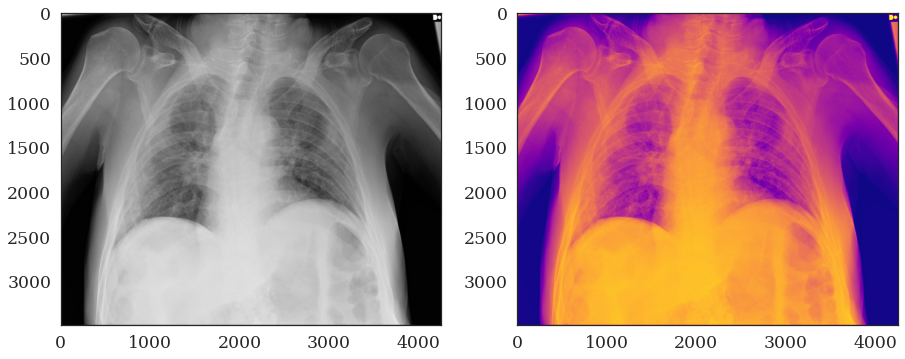

{'Accession Number': 'f6cd7f2019f5',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4256,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': 'dcc3fdf6426a',
 "Patient's Name": "'d4268f26ed05'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 3488,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'000a312787f2'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'81456c9c5423'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '526316e376d4',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'5776db0cec75'",
 'Study Time': '8ccfb6acf07f'}


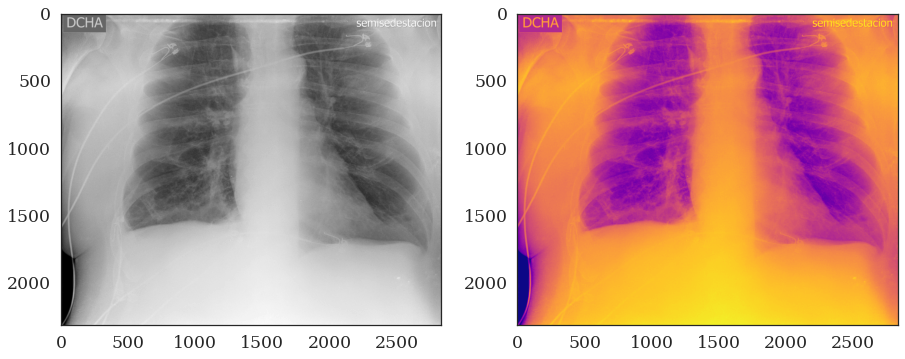

{'Accession Number': '1c2708371bc6',
 'Bits Allocated': 8,
 'Bits Stored': 8,
 'Body Part Examined': 'CHEST',
 'Columns': 2832,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 7,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.15, 0.15]',
 'Instance Number': 1,
 'Modality': 'CR',
 'Patient ID': 'f09ff9b7dab3',
 "Patient's Name": "'ef8c31f8dfdd'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2320,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'000c3a3f293f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'d8a644cc4f93'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'd09eda152722',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'ff0879eb20ed'",
 'Study Time': '543adb46f494'}


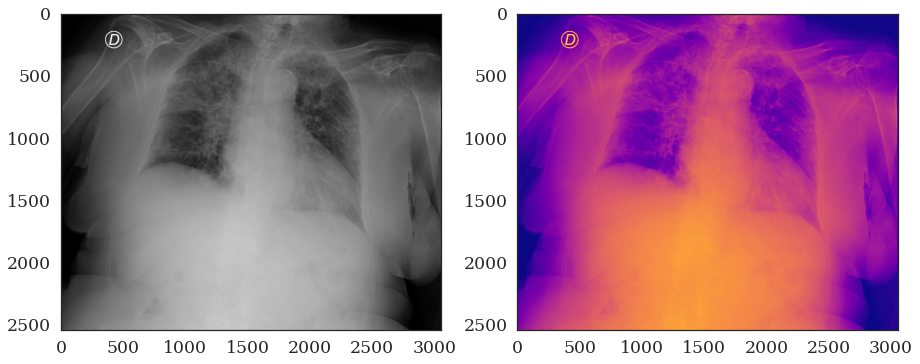

{'Accession Number': '99428f65d948',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'PORT CHEST',
 'Columns': 3056,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.139, 0.139]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '6a02c0731039',
 "Patient's Name": "'2f2fb944fe44'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME2',
 'Rows': 2544,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'0012ff7358bc'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'22897cd1daa0'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '96fc21dd2b1f',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'9d514ce429a7'",
 'Study Time': '746186a2bbf2'}


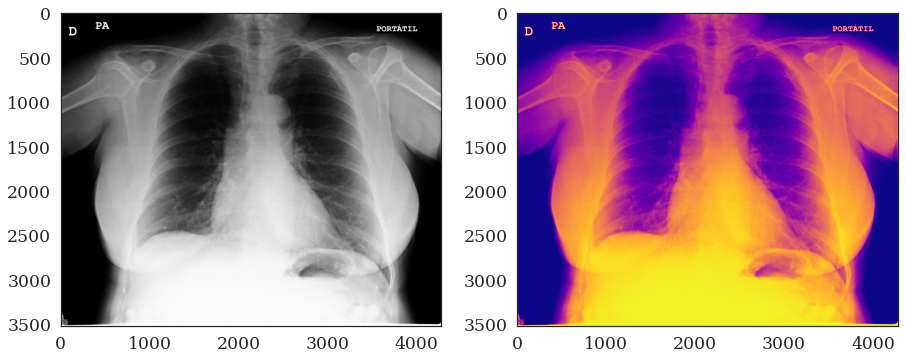

{'Accession Number': '7b889627faf1',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4280,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT', '', '', '', '', "
               "'100000']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1002,
 'Modality': 'CR',
 'Patient ID': 'db63d9b7f61c',
 "Patient's Name": "'9ccd87b4511b'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME1',
 'Private Creator': 'GEIIS',
 'Rows': 3520,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'001398f4ff4f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'4d47bc042ee6'",
 'Series Number': 1002,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '3f094e1700ec',
 'Study ID': '55625fb42f3f',
 'Study Instance

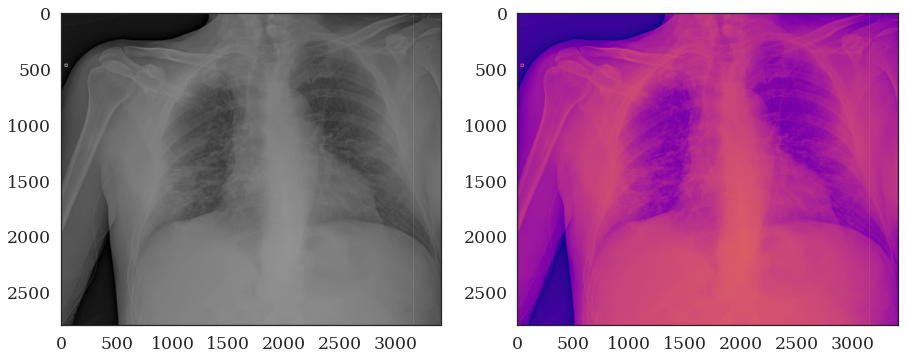

{'Accession Number': 'e9d93edf50c6',
 'Bits Allocated': 16,
 'Bits Stored': 15,
 'Body Part Examined': 'CHEST',
 'Columns': 3408,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 14,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.125, 0.125]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '605693f36f43',
 "Patient's Name": "'35bf9ddbf9e9'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME1',
 'Rows': 2800,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'001bd15d1891'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'49170afa4f27'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'a69d89c8a474',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'dfd9fdd85a3e'",
 'Study Time': '5399ff949226'}


In [ ]:
for filename in train_df.path[0:5]:
    df, img_array = dicom_dataset_to_dict(filename, 'fetch_both_values')
    fig, ax = plt.subplots(1, 2, figsize=[15, 8])
    ax[0].imshow(img_array, cmap=plt.cm.gray)
    ax[1].imshow(img_array, cmap=plt.cm.plasma)    
    plt.show()
    pprint.pprint(df)

In [ ]:
dicom_data_list = []
for filename in train_df.path:
    try:
        data_di = dicom_dataset_to_dict(filename,'metadata')
        dicom_data_list.append(data_di)
    except:
        continue
        
dicom_data_df = pd.DataFrame(dicom_data_list)
dicom_data_df

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


In [ ]:
dicom_data_list = []
for filename in train_df.path:
    try:
        data_di = dicom_dataset_to_dict(filename,'metadata_df')
        dicom_data_list.append(data_di)
    except:
        continue
dicom_data_df = pd.DataFrame(dicom_data_list) 
dicom_data_df

#====== Saving to csv files and creating artifacts ======
dicom_data_df.to_csv("dicom_metadata.csv")
run = wandb.init(project='siim', name='dicom_metadata')
artifact = wandb.Artifact('dicom_metadata', type='dataset')

#====== Add a file to the artifact's contents ======
artifact.add_file("dicom_metadata.csv")
#====== Save the artifact version to W&B and mark it as the output of this run ====== 
run.log_artifact(artifact)
run.finish()